# Hito 2 - AppEval

CC5205 - Minería de Datos

- Profesora: Jazmine Maldonado
- Auxiliar: Fran Zautzik

Integrantes:
- Felipe Avendaño
- Martín Bravo
- Franco González
- Daniel Radrigán
- Felipe Valdebenito

## 1. Introducción

En la actualidad, las redes sociales constituyen una de las principales formas de comunicación en el mundo. Algunas de estas redes concentran una cantidad tan grande de personas que las usan, que una alternativa a elas suena como algo impensable. Aún así, algunas corporaciones lanzan su perspectiva de como debiese ser alguna red social en cuestion (séase de ejemplo, la existencia de Telegram frente a WhatsApp como aplicaciones de mensajería instantánea). Dichas redes han sido desarrolladas en base a estudios de mercado, análisis de información, y para este caso, se mencionara el feedback otorgado directamente por los usuarios que conforman la plataforma en sí.

Comercialmente hablando, la retroalimentacion de los usuarios sobre una determinada aplicacion es determinante a la hora de realizar mejoras que atraigan y retengan usuarios dentro de la misma plataforma. Tomando esto en cuenta, dada la gran cantidad de comentarios negativos con descripciones vagas o de exagerada negatividad, se complejiza el poder obtener un feedback objetivo que indique precisamente las falencias de la app. Por estas razones, poder extraer determinados fragmentos que se frecuentan en comentarios negativos es de importancia para ayudar a las empresas a mantener la calidad de sus aplicaciones.

Los datos que se usarán en el proyecto a presentar, corresponden a reviews de usuarios de aplicaciones de redes sociales, en particular, la aplicación Threads. El estudio de estos datos puede permitir el observar que aspectos de las aplicaciones valoran los usuarios. Tambien permite entender las razones del porque no gusta determinada caracteristica. La elección de datos se basa en la relevancia que poseen para el desarrollo de nuevas redes sociales o mejoras de las ya existentes.

Para las emperesas es de particular interés el uso de tecnicas de mineria de datos para obtener los aspectos criticados en las reviews de la app a partir del análisis del lenguaje empleado.

Como bien se ha mencionado, estudiar estos datos nos permite entender cuales son los aspectos a mejorar de una app, los cuales no pueden ser conocidos mediante una simple puntuación numérica (e.g. 1-5 estrellas), pues solo indica el nivel de satisfacción que el usuario tiene sobre la app, sin otorgar detalle sobre la razón de dicha calificación.

## 2. Exploración de Datos

Por medio del uso de Python, junto con variadas librerias para la manipulación del dataset escogido, se procedera a la obtención de tablas y gráficos para extraer información general sobre los comentarios dados a la aplicación Threads. Dicha aplicación se basa en la publicación de mensajes breves a modo de que cada usuario participa en "foros" según los tópicos más importantes del día.

In [2]:
# Librerías

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import string # string manipulation
import re # regular expressions
import nltk # text manipulation
nltk.download('punkt')
nltk.download('stopwords')

from tqdm import trange # progress bar
from nltk import tokenize # text manipulation
from nltk.corpus import stopwords # text manipulation
from nltk.stem import WordNetLemmatizer # text manipulation
from nltk.probability import FreqDist # text manipulation
from collections import Counter # text manipulation
from sklearn.feature_extraction.text import CountVectorizer # text manipulation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # wordcloud generator
from IPython.display import display # image display
from PIL import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En primer lugar se mostrará una vista preliminar del dataset escogido. Para ver cantidad de columnas y los tipos de datos que se manejan:

In [3]:
data = pd.read_csv("threads.csv") # carga del dataset a usar como variable
data.head(10)

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43
5,Google Play,"Currently, it's very challenging to use. It's ...",2,2023-07-18 22:30:10
6,Google Play,I still don’t want to see content from people ...,1,2023-07-19 19:35:31
7,Google Play,Could be great if all pages loaded when you cl...,2,2023-07-06 14:35:15
8,Google Play,I'm liking the concept! There is room for impr...,3,2023-07-09 03:27:39
9,Google Play,Not bad! This is its first launch. There is st...,5,2023-07-06 23:41:13


Dicho dataset cuenta con 4 columnas, y 32910 filas. Las columnas son:
- Source: La procedencia de los comentarios (según el sistema operativo y la tienda de aplicaciones de la cual se descargó),
- Review Description: El comentario publicado, el cual contiene el detalle sobre la calificación otorgada a la aplicación.
- Rating: La puntuación otorgada, en una escala de 1 a 5, con 1 como puntuacion mala y 5 como excelente.
- Review Date: Fecha de publicación de la reseña, con detalle sobre el día, mes, año y hora de publicación.

Se hará una revisión a la cantidad de reseñas segun la calificación otorgada:

In [4]:
print(data["rating"].value_counts()) # contar la cantidad de reviews recibidas segun el rating de 1 a 5

# muestra mediana, media, desviación estándar, mínimo y máximo de la variable "replies"
data.describe()

5    15559
1     9726
4     3244
3     2585
2     1796
Name: rating, dtype: int64


,rating
count,32910.000000
mean,3.398481
std,1.751480
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


Podemos ver que el promedio de los ratings es de 3.4, lo cual es un valor bastante bajo, además podemos observar que la mayoría de reseñas son de 5 estrellas, y luego vienen las de 1 estrella, esto nos sugiere dividir las reseñas en distintos grupos.

A partir de estos datos, se puede generar un gráfico de pastel. Primero, se realizará una conversión del rating según rangos. Dichos rangos son: 1-2 estrellas como NEGATIVO, 3-4  estrellas como NEUTRAL y 5 estrellas como POSITIVO. El gráfico generado se muestra a continuación.

La razón de esta elección es debido a que los comentarios de 1-2 estrellas suelen ser de tipos negativos, mientras que los de 5 estrellas suelen ser positivos. Los comentarios de 3-4 estrellas se pondrán como neutrales, ya que dicen algo positivo de la aplicación, pero también mencionan algo negativo (en un principio se dejó neutral como 3 estrellas pero esto generaba muy poca cantidad de reseñas neutrales).

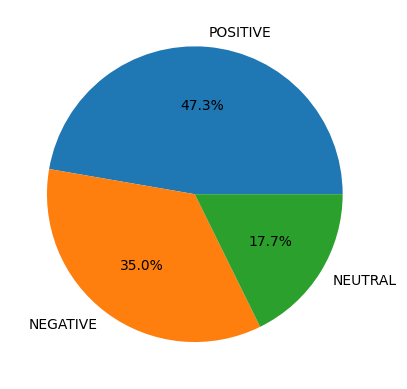

In [5]:
# función para convertir el rating a palabras
def ratingTransform(rating):
    if rating <= 2:
        return "NEGATIVE"
    elif rating <= 4:
        return "NEUTRAL"
    else:
        return "POSITIVE"

# creacion del grafico de pie de las reviews segun rating
data["rating"] = data["rating"].apply(ratingTransform)
plt.pie(data["rating"].value_counts(), labels=data["rating"].value_counts().index, autopct='%1.1f%%')
plt.show()

Se puede ver que la mayoría de las reseñas son positivas, siguiendo en cantidad las negativas y por último las neutrales. Esto sugiere que la aplicación se considera buena, pero tiene algunos problemas que se pueden mejorar.

Ya que nuestro dataset contiene en su mayoría texto, se generarán columnas que ayudarán a analizarlo. Estas columnas serán:
- Review Length: Largo del comentario.
- Word Count: Cantidad de palabras que contiene el comentario.
- Mean Word Length: Promedio de largo de las palabras del comentario.
- Mean Sentence Length: Promedio de largo de las oraciones del comentario.

Estas columnas apoyarán en la realización de gráficos basados en atributos provenientes del texto.

In [6]:
# tabla generada con el largo en caracteres de las reviews escritas
data['Length'] = data['review_description'].str.len()
# numero de palabras en la primera review del dataset
word_count = data['review_description'][0].split()
# funcion para separar una oracion y contar la cantidad de palabras que posee
def word_count(review):
    review_list = review.split()
    return len(review_list)
# generacion de nueva columna de cantidad de palabras por review
data['Word_count'] = data['review_description'].apply(word_count)
# largo promedio de las palabras en cada review
data['mean_word_length'] = data['review_description'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
# largo promedio de las oraciones en cada review
np.mean([len(sent) for sent in tokenize.sent_tokenize(data['review_description'][0])])
data['mean_sent_length'] = data['review_description'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

data.head(10)

,source,review_description,rating,review_date,Length,Word_count,mean_word_length,mean_sent_length
0,Google Play,Meh. Not the greatest experience on a Chromebo...,NEGATIVE,2023-07-08 14:18:24,465,85,4.482353,65.571429
1,Google Play,Pretty good for a first launch!! Its easy to u...,NEUTRAL,2023-07-19 20:52:48,475,81,4.876543,157.666667
2,Google Play,"For a brand new app, it's very well optimized....",NEUTRAL,2023-07-06 23:03:11,497,91,4.472527,70.142857
3,Google Play,"Great app with a lot of potential! However, th...",NEUTRAL,2023-07-10 00:53:25,487,94,4.191489,80.333333
4,Google Play,"The app is good, but it needs a lot of functio...",NEUTRAL,2023-07-06 16:57:43,426,79,4.405063,84.400000
5,Google Play,"Currently, it's very challenging to use. It's ...",NEGATIVE,2023-07-18 22:30:10,386,75,4.160000,47.375000
6,Google Play,I still don’t want to see content from people ...,NEGATIVE,2023-07-19 19:35:31,438,81,4.419753,86.800000
7,Google Play,Could be great if all pages loaded when you cl...,NEGATIVE,2023-07-06 14:35:15,365,67,4.462687,60.000000
8,Google Play,I'm liking the concept! There is room for impr...,NEUTRAL,2023-07-09 03:27:39,416,86,3.848837,40.700000
9,Google Play,Not bad! This is its first launch. There is st...,POSITIVE,2023-07-06 23:41:13,328,55,4.981818,46.000000


A partir de la tabla anterior, se pueden extraer los siguientes gráficos, cada uno basado en cada una de las columnas creadas:

['Length', 'Word_count', 'mean_word_length', 'mean_sent_length']



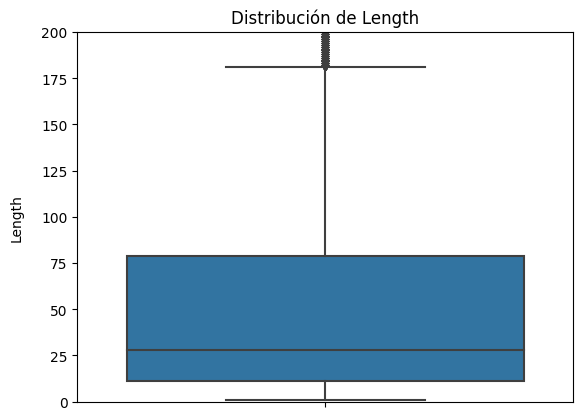

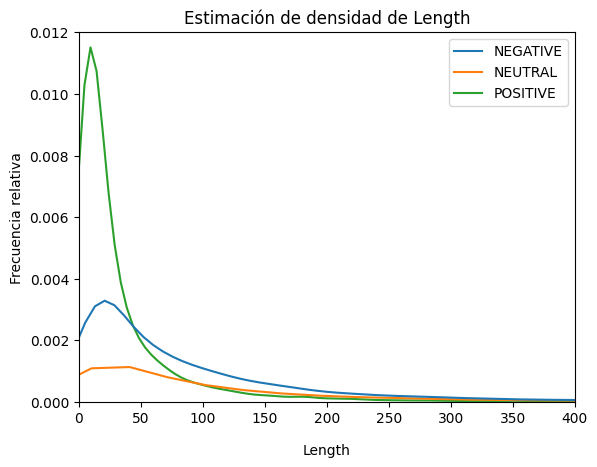

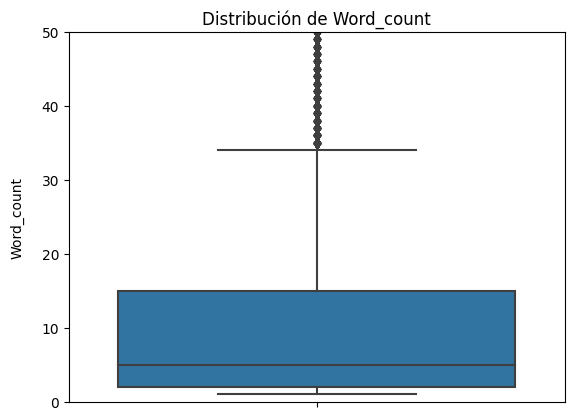

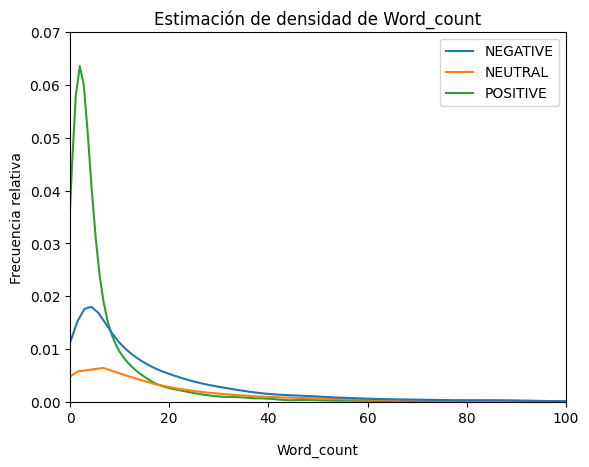

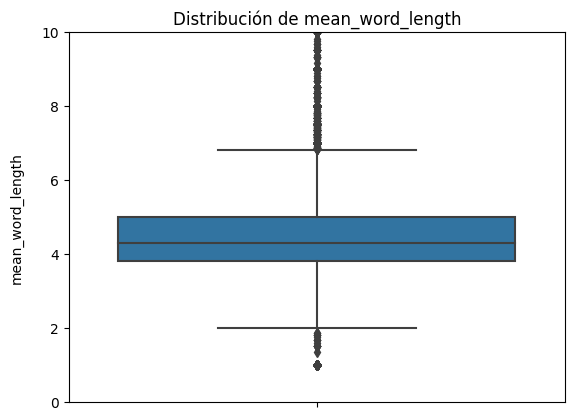

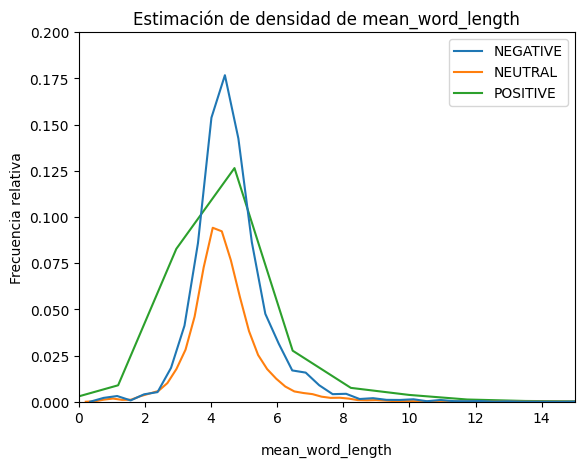

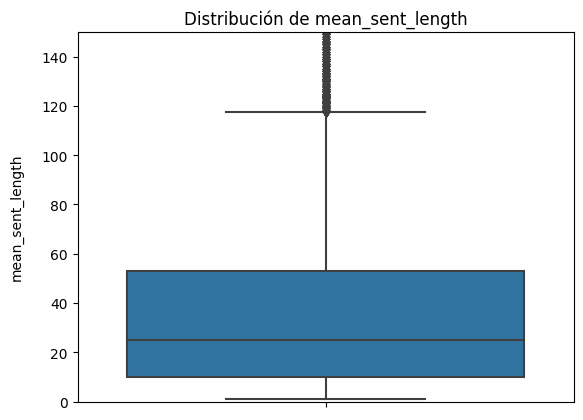

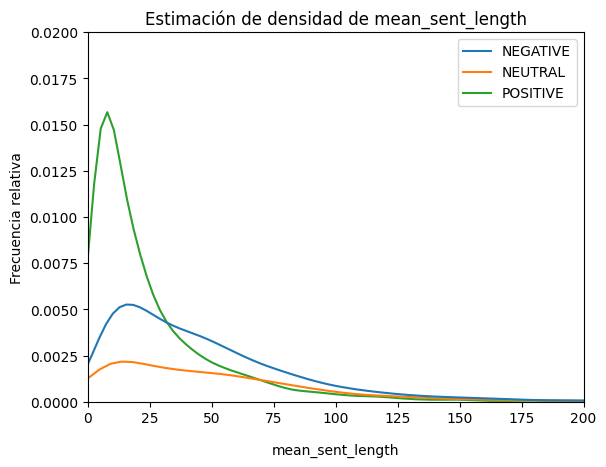

In [7]:
# creacion del boxplot de las palabras
def visualize(col, ind=0, max_ys_k=[0.012,0.07,0.2,0.02], max_xs_k=[400,100,15,200], max_ys_b =[200,50,10,150]):

    print()
    plt.plot(1,2,1)
    sns.boxplot(y=data[col], hue=data['rating'])
    plt.title('Distribución de '+col)
    plt.ylabel(col, labelpad=12.5)
    plt.ylim(0,max_ys_b[ind])
    plt.show()

    plt.plot(1,2,2)
    sns.kdeplot(data=data, x=col, hue='rating')
    plt.legend(data['rating'].unique())
    plt.ylim([0,max_ys_k[ind]])
    plt.xlim([0,max_xs_k[ind]])
    plt.title('Estimación de densidad de '+col)
    plt.xlabel(col, labelpad=12.5)
    plt.ylabel('Frecuencia relativa')



    plt.show()

features = data.columns.tolist()[4:]
print(features)
i = 0
for feature in features:
    visualize(feature,ind=i)
    i+=1

Observaciones con respecto a los gráficos:

- Review Length:

La mayoria de los largos de los comentarios son menores a 75 caracteres, es decir, los comentarios suelen ser cortos, en especial los comentarios positivos. Podemos notar que mientras los comentarios positivos suelen ser cortos, los comentarios neutrales estan mas equilibrados y los comentarios negativos también, auque estos últimos también tiene una alta frecuencia de comentarios cortos.

Por lo anterior, se puede decir que los comentarios con mayor información deberian ser aquellos que muestran descontento por la aplicación, probablemente por que en su comentario hablan del problema que tienen con la aplicación, mientras que comentarios más positivos puede ser que solo destaquen aquello que les gusta sin necesidad de extenderse mucho en el porque.

- Word Count:

Las conclusiones anteriores también se extienden a la cantidad de palabras utilizadas en el comentario, ya que estan muy relacionados. La frecuencia de la cantidad de palabras también esta concentrada en valores bajos y se comporta igual que el largo con respecto a comentarios positivos, neutrales y negativos.

- Mean Word Length:

Podemos observar que el largo promedio de las palabras utilizadas pareciera seguir una distribucion normal, lo cual tine relacion con las palabras que se utilizan para escribir las reseñas, que una reseña tenga un largo de palabras muy alto indicaria la utilizacion de un lenguaje mas tecnico y complicado, en cambio aquellos comentarios con promedios de palabras mas cortos problablemente utilizan muchas palabras que aportan poco al mensaje.

También podemos notar que en general los comentarios positivos estan mas distribuidos en cuanto al largo promedio de las palabras, en cambio los comentarios negativos se concentran mucho más en torno al valor promedio.

- Mean Sentence Length:

Con respecto al largo promedio de las oraciones de los comentarios podemos ver que en general también se concentran en valores bajos, pero esto es mas notorio para los comentarios positivos que probablemente solo destacan lo positivo de la aplicacion mientras que los neutrales y los negativos estan más distribuidos y tienen mayor frecuencia en valores más grandes problablemente porque muestran su descontento o describen su problema con la aplicación, lo cual los puede llevar a escribir un comentario más largo y complejo.

### Analisis de frecuencia de términos

Haremos uso de la librería NLTK, la cual permite realizar un análisis de frecuencia de términos. Para esto, primero se debe limpiar el texto, eliminando signos de puntuación, números, stopwords, etc. Esto se realiza gracias a que internamente NLTK posee una lista de stopwords en inglés, la cual se usará para eliminarlas. Además, se hará uso de la librería string para eliminar signos de puntuación y números.

In [8]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

data['review_description'] = data['review_description'].apply(clean)



Posterior a la limpieza, se procede a incluir las palabras generadas a una lista, con la cual se extraerán las 10 palabras más comunes dentro de todas las reseñas. A continuación, se muestra un gráfico con los resultados obtenidos, conteniendo el Top 10 de palabras más comunes.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32910/32910 [00:00<00:00, 150289.28it/s]


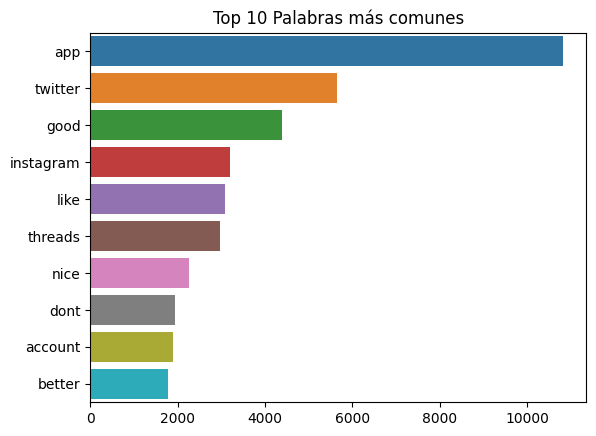

In [9]:
def corpus(text):
    text_list = text.split()
    return text_list

data['review_lists'] = data['review_description'].apply(corpus)

corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['review_lists'][i]

mostCommon = Counter(corpus).most_common(10)

words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Top 10 Palabras más comunes')
plt.show()

Con respecto a las palabras más comunes, es dificil poder concluir algo ya que no se tiene el contexto en el que se estan utilizando pero aun asi se pueden decir algunas cosas.

Que tanto "app" como "instagram" esten entre las palabras más frecuentes no es extraño ya que hacen referencia a la propia aplicacion sobre la cual trata el comentario.

Una palabra que puede resultar más extraño que sea tan comun es "twitter", esto probablemente esta relacionado con que son competencia, por lo que los usuarios siempre van a hacer comparaciones para decir si una aplicacion es mejor o peor a otra, en este caso no podemos identificar el contexto en el que se utiliza la palabra "twitter" pero podemos suponer que se utiliza para decir que instagram es peor o mejor que "twitter" en alguna de sus características.

Otras palabras como "good", "like", "nice" y "better" probablemente son parte de comentarios positivos, aunque no significa que no puedan estar en uno neutral o negativo, estan palabras tambien son bastante comunes y son de un uso muy general, además los comentarios positivos representan gran parte del data set, por lo estan palabras no nos aportan tanto.

Otra palabra comun es "dont", pero esta palabra es de un uso muy general asi que no sorprende que sea frecuente, además no podemos interpretar el contexto en el que se utiliza ya que "dont" podría ser utilizado tanto para un comentario positivo como negativo, aún así uno prodría pensar que la palabra estaría más relacionada con comentarios negativos y prodrá relacionarse con algo que quizá no les gusta a los usuarios o no les funciona.

Las palabras "threads" y "account" hacen referencia a caracteristicas de la aplicación, es difícil concluir algo ya que el comentario puede ser positivo o negativo, lo único que podemos decir es que el comentario probablemente es más extenso en su contenido al estar hablando de algún tema en específico de la aplicación.



---



También, posterior a la limpieza, es posible generar nubes de palabras basadas en la cantidad de palabras por Rating, esto nos permitira un mejor analizis de las palabras frecuentes ya que tendremos un mayor contexto para poder realizar el analisis. Los Wordclouds que se puedieron extraer son los siguientes:

In [10]:
# generacion de la wordcloud para definir cuales pueden ser las palabras mas importantes
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

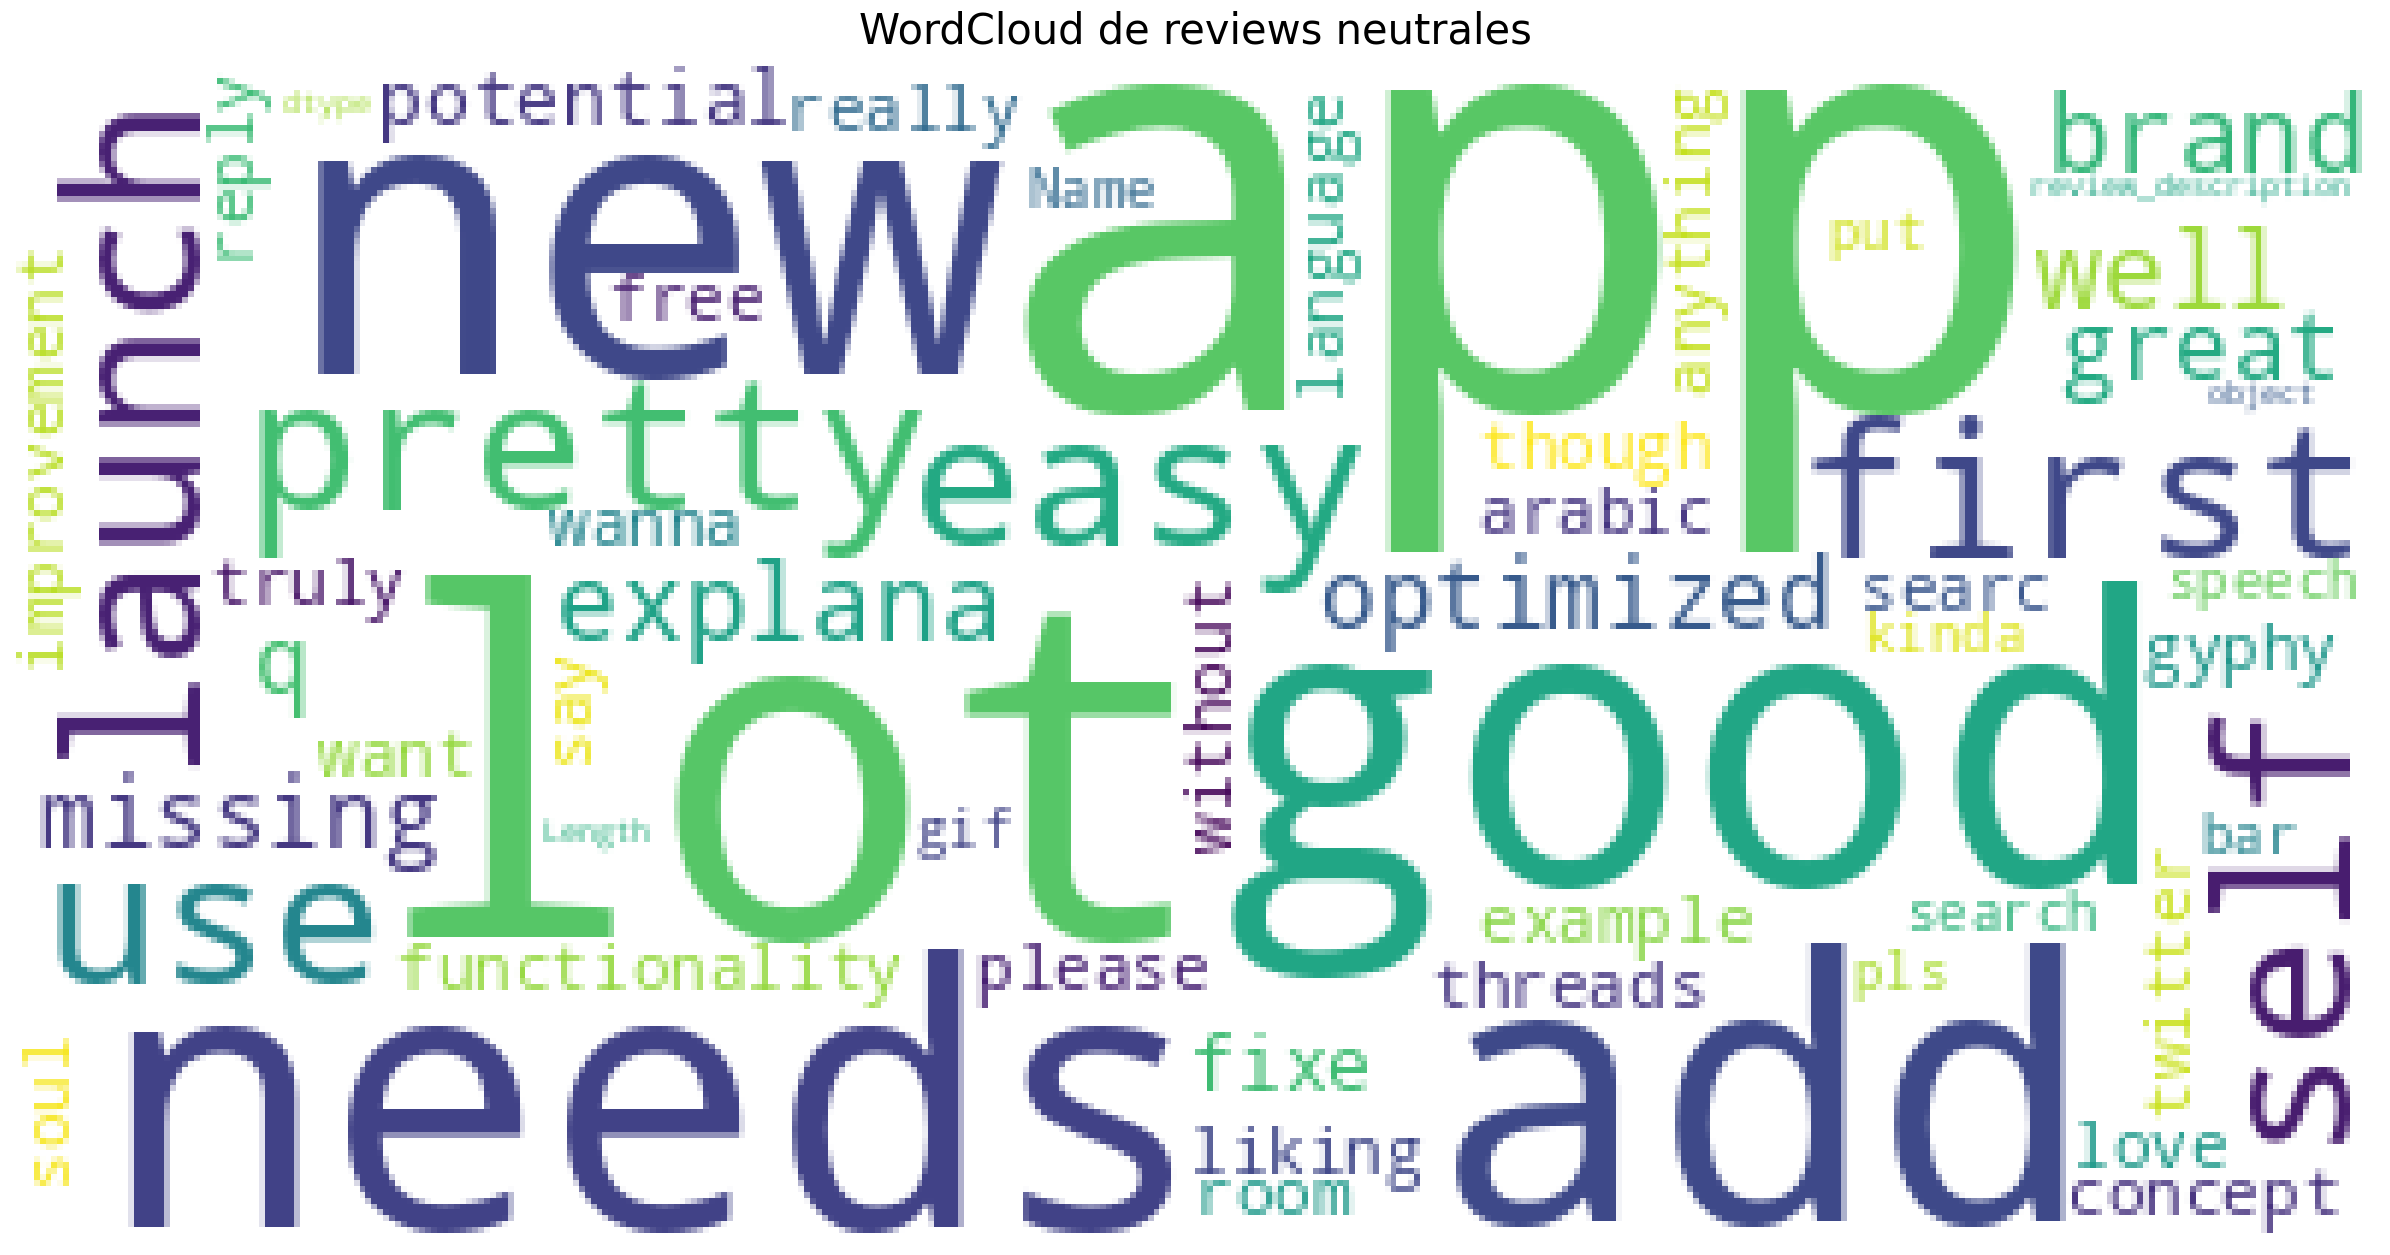

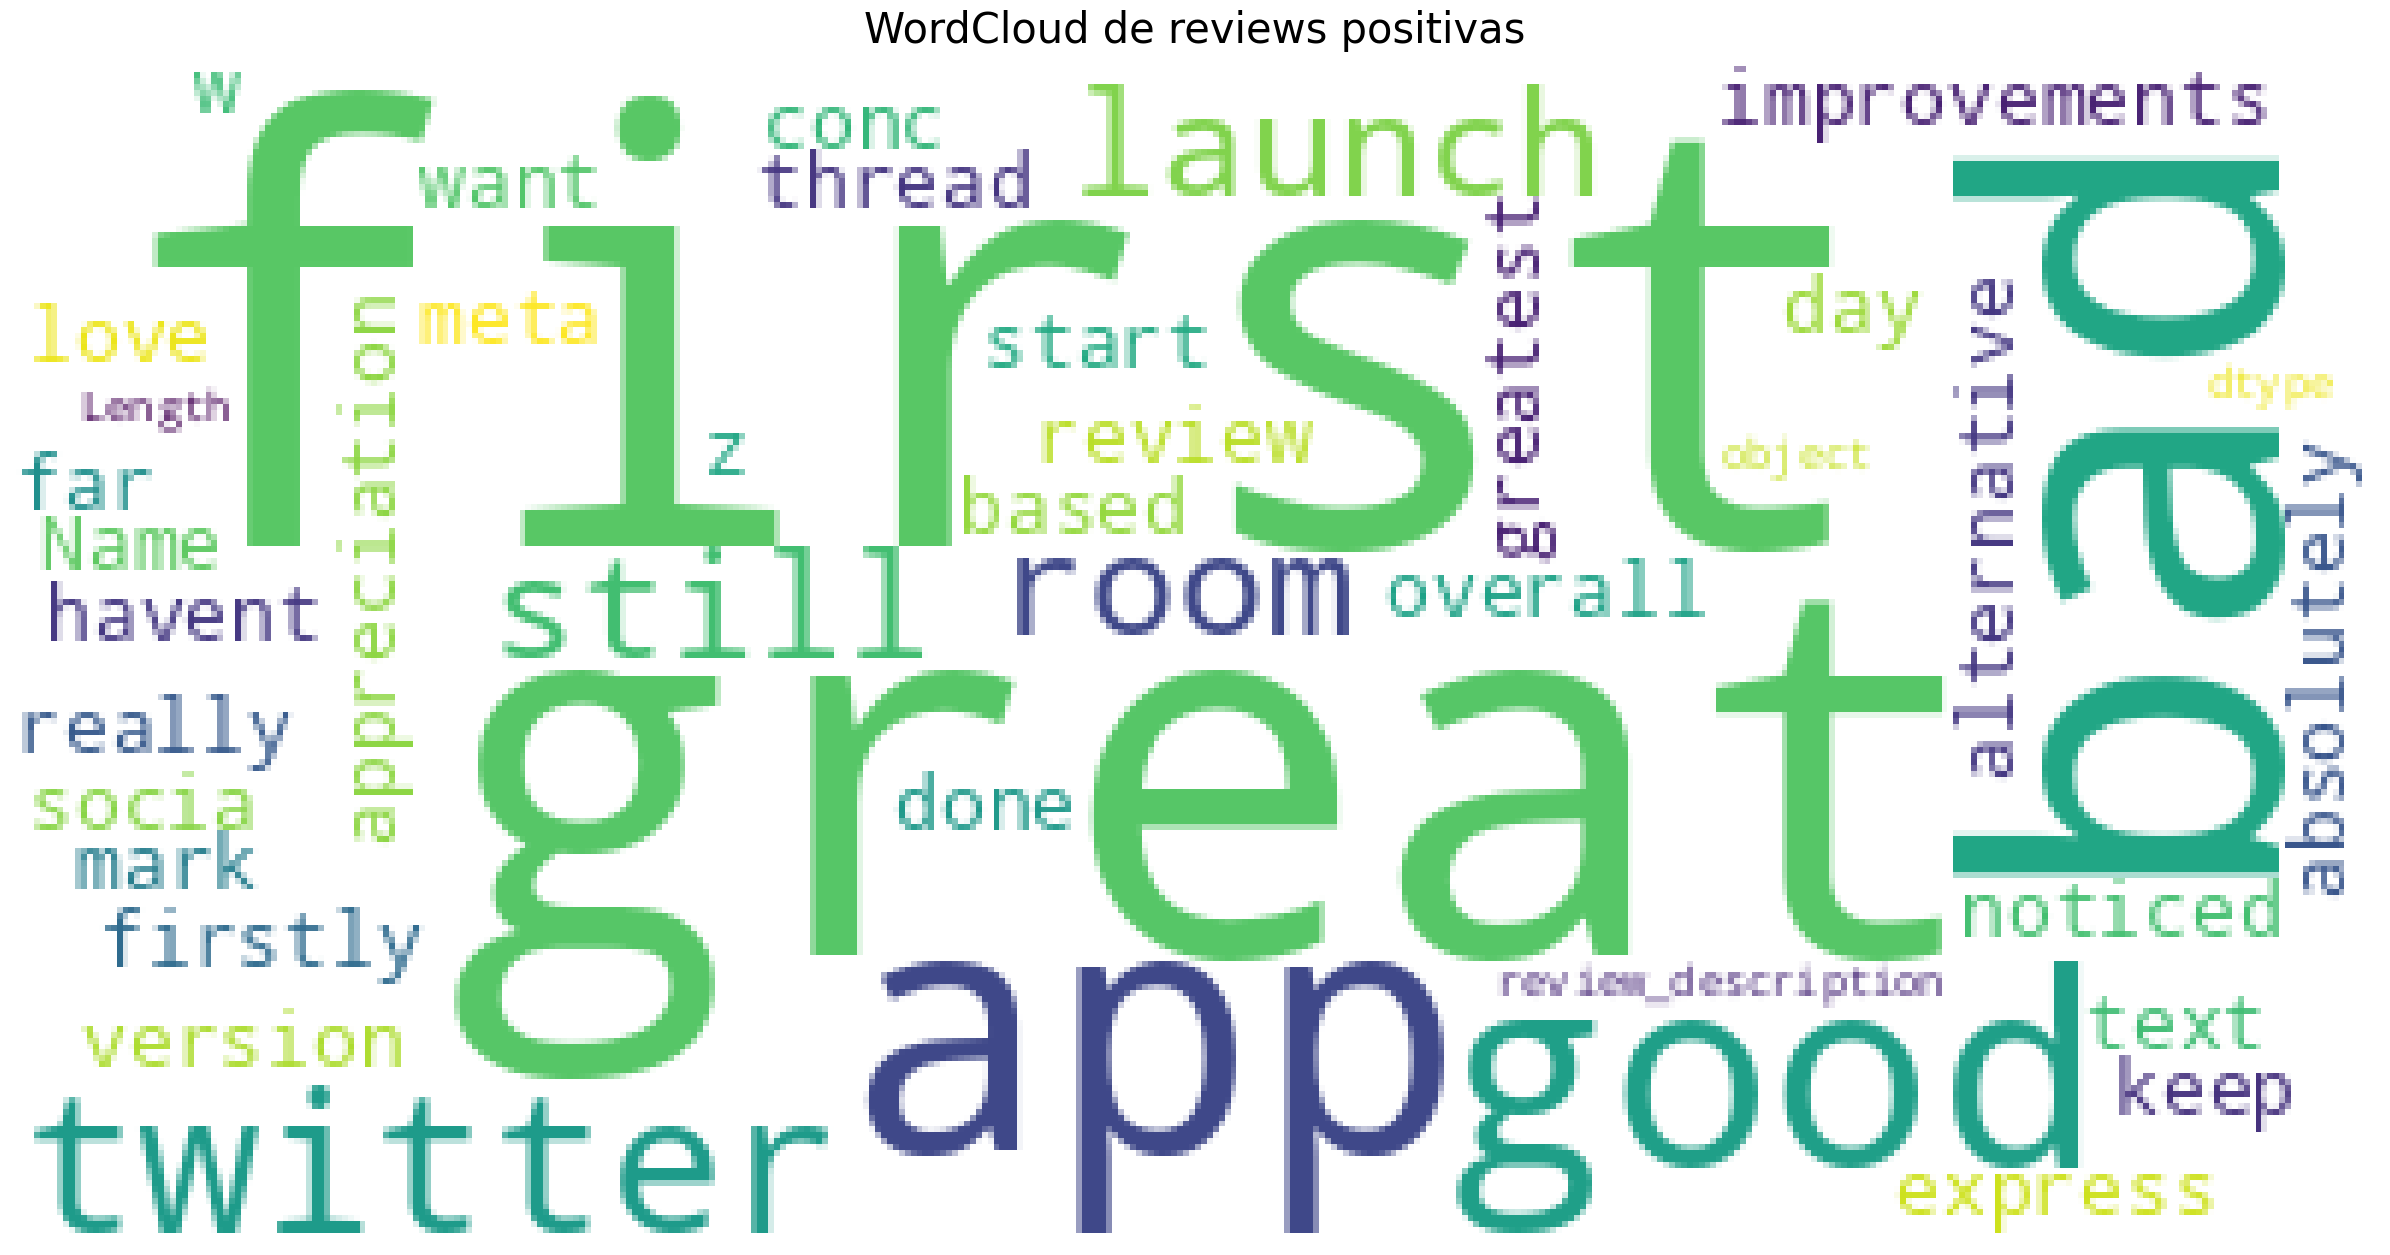

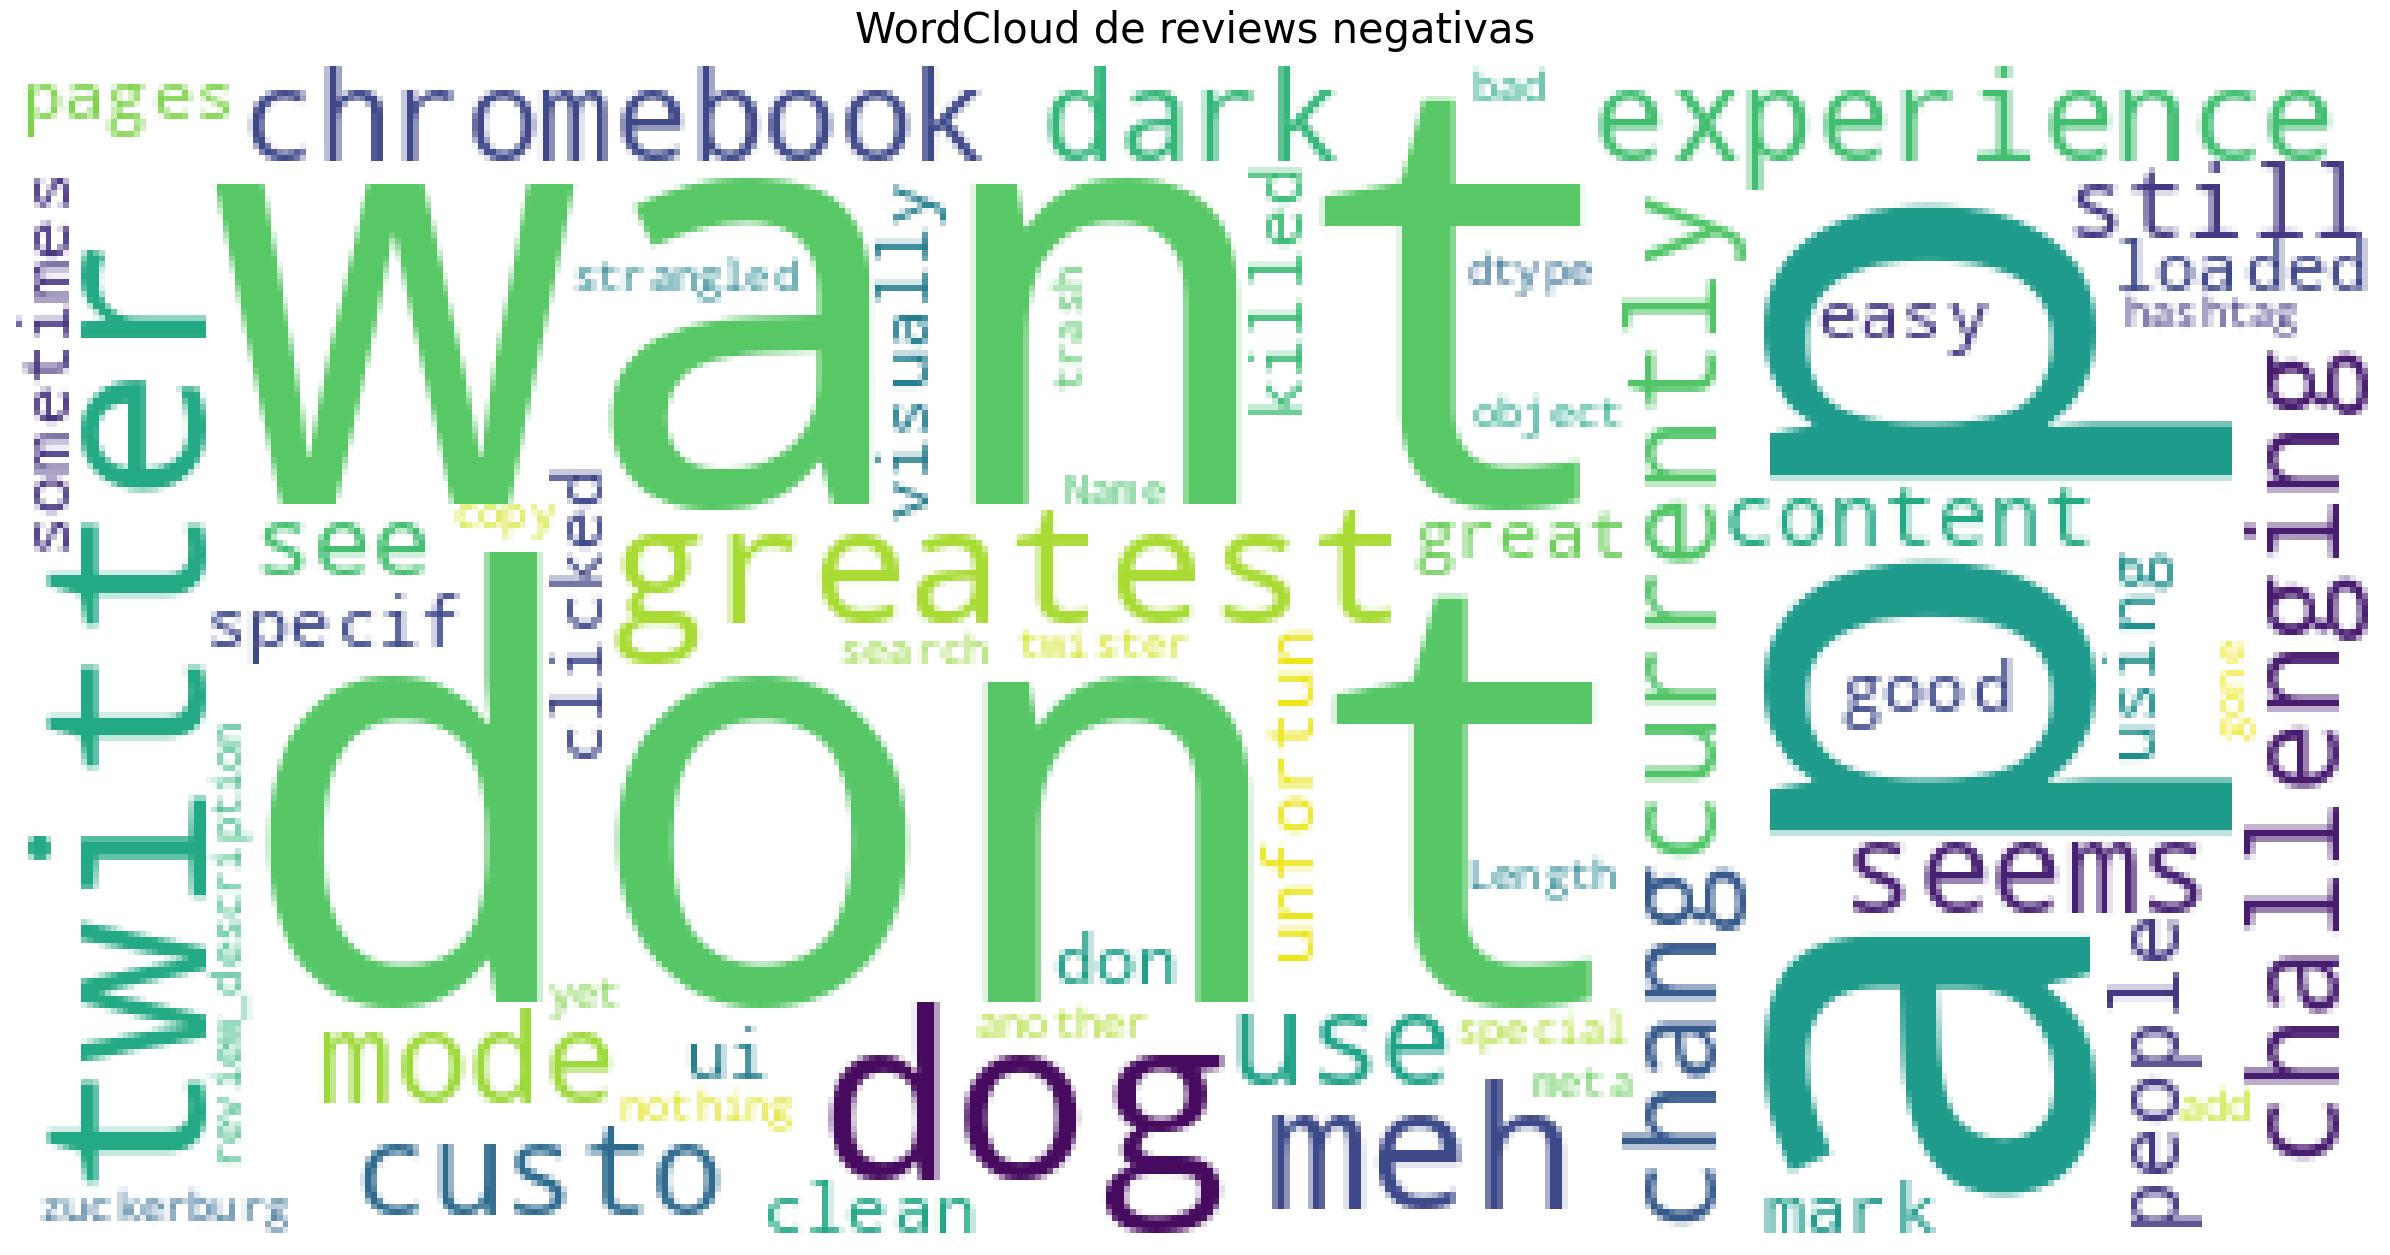

In [11]:
Neutral_rev = data[data["rating"] == "NEUTRAL"]
plot_wordcloud(Neutral_rev.review_description,color='white',max_font_size=100,title_size=30,title="WordCloud de reviews neutrales")
Posit_rev = data[data["rating"] == "POSITIVE"]
plot_wordcloud(Posit_rev.review_description,color='white',max_font_size=100,title_size=30,title="WordCloud de reviews positivas")
Neg_rev = data[data["rating"] == "NEGATIVE"]
plot_wordcloud(Neg_rev.review_description,color='white',max_font_size=100,title_size=30,title="WordCloud de reviews negativas")

### Los $N-$ gramas mas frecuentes

Los $N-$ gramas son secuencias de $N$ palabras consecutivas en un texto. Estos nos permitirán dar un mayor contexto a las palabras con mayor frecuencia recién vistas. A continuación veremos los 10 $2-$ gramas y $3-$ gramas más frecuentes.

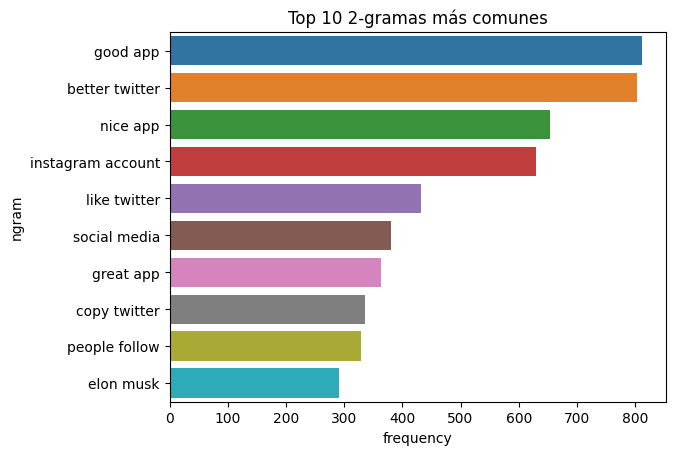

In [12]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['review_description'])

count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 2-gramas más comunes')
plt.show()

El 2-grama nos permite complementar la informacion anterios y tener un mayor contexto ya ahora son grupos de palabras y no palabras sueltas, esto nos permite obtener mejores conclusiones con respecto a palabras mas frecuentes. Por ejemplo podemos ver que en general "good" va seguido de "app", lo cual refuerza algunas de las cosas dichas anteriormente como que las reseñas positivas van dirigidas a temas mas generales y no tanto a un problemas más específico. También vemos que esta "better twitter" o "copy twitter", lo cual también refuerza parte de lo dicho anteriormente ya que estos comentarios, problablemente negativos, comparan la aplicación con twitter y valora una aplicación por sobre la otra. Otros comentarios siguen sin tener mucho sentido al no tener contexto, como "social media", frase que tiene mucha relacion con la aplicación pero es no se puede decir con certeza si se esta utilizando en un contexto positivo, negativo o neutral. El tener a "elon musk" como 2-grama frecuente problablemente se relaciona con la rivalidad entre aplicaciones y todos los eventos recientes con respecto a Elon Musk y la compra de twitter, lo cual probablemente provoco un aumento significativo en los comentarios con respecto a ese tema.

Se mostrará lo obtenido con 3-gramas, siendo las frases de tres palabras mas recurrentes en las reseñas:

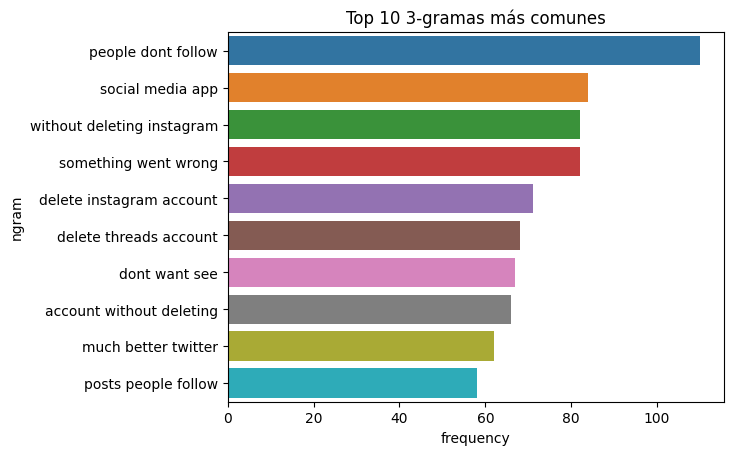

In [13]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(data['review_description'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 3-gramas más comunes')
plt.show()

Con 3-gramas tenemos incluso más información que antes, aunque siguen habiendo frases que podrian utilizarse en casi cualquier contexto.

Podemos ver que hay algunos del estilo "something wetn wrong", que problablemente son comentarios negativos hablando del mal funcionamiento de la app y puede que sea un comentario más complejo de lo normal a al contener más que solo una crítica general.

También podemos notar que hay muchas frases con delete como "wihtout deleting instagram", "delete instagram account" o "delete threads account", solo leyendo estas frases no se puede concluir a que estan haciendo referencia pero probablemente estan describiendo algún problema que tuvieron con el uso de la aplicación, por lo que probablemente son comentarios negativos, y si hay muchas personas con el mismo problema tiene sentido que esten entre las frases más frecuentes al ser un problema que afecta a muchos usuarios.

Como se pudo ver en los otros casos, persiste la rivalidad entre aplicaciones con comentarios como "much better twitter", de hecho esta frase complementa todo lo que se ha dicho anteriormente y el como muchos usuarios prefieren twitter por sobre instagram.

El 3-grama más común es "people dont follow", podriamos decir que el comentario es negativo ya que pareciera ser una queja con respecto a la aplicación o a los usuarios de la misma, aunque la frase sigue sin tener el contexto necesario para poder hacer una conclusión con respecto a porque aparece entre las frases más comunes entre las reseñas.

Para el caso de los 3-gramas podemos notar que la mayoría de las frases parecieran estar relacionadas con aspectos negativos de la aplicación, contrario a lo que vimos en el caso de palabras y 2-gramas más frecuentes. Lo anterior parece tener relación con una observacion anterior en la que se dijo que los comentarios positivos probablemente destacan aquello que les gusta mientras que los comentarios más neutrales o negativos describen su problema o hablan de forma más especifica con respecto a alguna característica de la aplicación.


## 3. Preguntas y Problemas

1. ¿Es posible predecir si una reseña es positiva o negativo dado ciertos N-gramas?
2. ¿que cluster se forman?
3. ¿como cambian las revies segun fecha como medida de la versión?

# Hito 2

Primero vamos a añadir y editar algunas columnas para poder trabajar mejor con los datos.

In [14]:
# Eliminaremos review_lists ya que solo eran para visualizar los datos
data = data.drop(['review_lists'], axis=1)
# Pasaremos las fechas a formato datetime
# Dias
data['review_date'] = pd.to_datetime(data['review_date']).apply(lambda x: (x.value)//(1_000_000_000*60*60*24))
# normalizar 0 a 1  las fechas
data['review_date'] = (data['review_date'] - data['review_date'].min()) / (data['review_date'].max() - data['review_date'].min())
# normalizar 0 a 1 length, wordcount, mean_word_length, mean_sent_length
data['Length'] = (data['Length'] - data['Length'].min()) / (data['Length'].max() - data['Length'].min())
data['Word_count'] = (data['Word_count'] - data['Word_count'].min()) / (data['Word_count'].max() - data['Word_count'].min())
data['mean_word_length'] = (data['mean_word_length'] - data['mean_word_length'].min()) / (data['mean_word_length'].max() - data['mean_word_length'].min())
data['mean_sent_length'] = (data['mean_sent_length'] - data['mean_sent_length'].min()) / (data['mean_sent_length'].max() - data['mean_sent_length'].min()) #
# Pasaremos algunas columnas a categoricas source, rating a int
data['source'] = data['source'].apply(lambda x: 1 if x == "Google Play" else 0)
# Ya que no necesitamos que sea visual los pasamos a entero
def ratingTransform(rating):
    if rating == "POSITIVE":
        return 2
    elif rating == "NEUTRAL":
        return 1
    else:
        return 0
data['rating'] = data['rating'].apply(ratingTransform)
# verifiquemos los tipos de columna
data.dtypes

source                  int64
review_description     object
rating                  int64
review_date           float64
Length                float64
Word_count            float64
mean_word_length      float64
mean_sent_length      float64
dtype: object

Definiremos nuestro $X$ y nuestro $Y$

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data["review_description"])


bigrams = pd.DataFrame(bigrams.toarray(), columns=cv.get_feature_names_out())
trigrams = pd.DataFrame(trigrams.toarray(), columns=cv1.get_feature_names_out())
vectorized = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

vdata = data.drop(['review_description'], axis=1)

# Definimos X e Y
X = data.drop(['rating'], axis=1)
X_NotDate = X.drop(['review_date'], axis=1)
X_1gram = vectorized
X_2gram = bigrams
X_3gram = trigrams
Y = data['rating']



,00 ki,010 recommend,010 wont,0210 dayi,05 10,05 far,06 07,06 july,07 2023,07 23,...,zukor bark,zuku bhai,zuku brother,zuku chacha,zuku fork,zukubarg bakwas,zukya bhai,zurorat ni,zyada better,zyada honge
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32908,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Datasets que vamos a generar:

$X_{NotDate}$: Los datos sin la columna fecha

$X$: Todos los datos

$X_{1-gram}$: Solo los datos de la columna Review Description, pero con los $1-$gramas


$X_{2-gram}$: Solo los datos de la columna Review Description, pero con los $2-$gramas

$X_{3-gram}$: Solo los datos de la columna Review Description, pero con los $3-$gramas

## Clustering




In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree

## PCA

In [17]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)



ValueError: ignored

In [ ]:
#visualizar datos
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA')
plt.show()

In [ ]:
# kmeans
sse = []

clusters = list(range(1,16))
for i in clusters:
    kmeans = KMeans(n_clusters=i, n_init="auto", max_iter=100, random_state=42).fit(X) # fit retorna a self
    sse.append(kmeans.inertia_)

In [ ]:
plt.plot(clusters, sse, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

Dividiremos el dataset para test y train, tomando el clustering usaremos x categorias

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=37,stratify=Y)


In [ ]:
# matriz de confusion
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
review = "nigger"
print(clf.predict(vectorizer.transform([review])))


In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(23,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 4, feature_names=vectorizer.get_feature_names_out(), class_names=clf.classes_, filled=True)
plt.show()

In [ ]:
columnas = X.columns
l = [1039, 2633, 3759, 4222, 4185, 2672, 6158]

print("La palabra mas relevante para la decision de categorias es: "+columnas[l[0]])
print("Luego les siguen en el arbol las palabras: "+columnas[l[1]]+ " e "+columnas[l[2]])
print("A altura 3 en el arbol, las palabras son: ")
for i in l[3:]:
    print("  "+columnas[i])

Podemos ver que las palabras mas significativas no son buenas para evaluar bien a que se refiere

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['review_description'])
X = pd.DataFrame(bigrams.toarray())
Y = data["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.33, random_state=37,stratify=Y)
clf = DecisionTreeClassifier()

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy en test set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree=clf, fontsize=7, max_depth = 3)
plt.show()

In [ ]:
columnas = X.columns
l = [48842, 12963, 95756, 21456, 101894, 24732]

print("La palabra mas relevante para la decision de categorias es: "+str(columnas[l[0]]))
print("Luego les siguen en el arbol las palabras: "+str(columnas[l[1]])+ " e "+str(columnas[l[2]]))
print("A altura 3 en el arbol, las palabras son: ")
for i in l[3:]:
    print("  "+str(columnas[i]))